# # 모듈
---

In [ ]:
# !git clone https://github.com/Bharath2/Informed-RRT-star
# %cd /content/Informed-RRT-star
# %pip install -qr requirements.txt
!pip install rtree
!pip install pymysql
!pip install pyproj
!pip install geopandas
!pip install pyshp

# 그리드 구성
import numpy as np
import sys
import re
import matplotlib.pyplot as plt
import pymysql
import pandas as pd
import geopandas as gpd
import shapely.geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

# DQN
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, PReLU, ReLU, Conv2D, Input, Flatten
from tensorflow.keras.optimizers import SGD , Adam, RMSprop
import matplotlib.pyplot as plt
%matplotlib inline

# informed RRT*
import sys
sys.path.append("/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/Informed-RRT-star/")
import numpy as np
import re
import pymysql
import pandas as pd
import geopandas as gpd
from PathPlanning import RRT, RRTStar, Map
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 991 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.4 MB/s 
     |████████████████████████████████| 16.7 MB 28.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.4 MB/s 


# # DQN
---

In [ ]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
# epsilon = 0.1
epsilon = 0.15

# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

# 지도 구성
class Qmaze(object):
    def __init__(self, maze, rat, target):  # maze는 맵 그린 array, rat은 드론 좌표

        self._maze = np.array(maze)  # array 복사
        nrows, ncols = self._maze.shape  # 맵의 가로 세로 길이

        # print("타겟: ",self.target[0][0], self.target[1][0])
        # m, n = np.where(maze == 10)  # array에서 2를 찾고 행 렬 성분을 가짐 pks
        self.target = target  # 목표점

        # 1인 부분은 free_cell이라 지정 ( 이중 for문 )
        # free_cells는 (r,c) free_cell 좌표를 담은 배열
        self.block_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 0.0]
        self.free_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] >= 1.0]
        self.cost1_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 1.0]
        self.cost2_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 2.0]
        self.cost3_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 3.0]
        self.cost4_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 4.0]
        self.cost5_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 5.0]
        self.cost6_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 6.0]

        # self.waypoint = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 2.0]  # 경유지
        # self.total_waypoint_size = len(self.waypoint)
        # self.waypoint_count = 0
        
        # 목표점은 free_cell이 아니기 때문에 배열에서 제거
        # self.free_cells.remove(self.target)

        # 목표점을 0인 곳에 정의 했을 때
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")

        # 드론의 위치를 범위 밖에 정의했을 때
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat  # 드론 좌표

        self.maze = np.copy(self._maze)  # 맵 배열을 다시 받아옴
        # self.maze = np.random.permutation(self._maze) # 맵 배열 섞기

        row, col = rat
        col_size = abs(self.rat[0] - self.target[0]) + 1
        row_size = abs(self.rat[1] - self.target[1]) + 1
        #self.maze[row, col] = rat_mark  # 드론 위치 표시해 줌
        self.state = (row, col, 'start')  # 스테이트 초기화 - > start
        # self.min_reward = -0.5 * self.maze.size  # size 값은 가로 곱하기 세로

        # col_size = abs(self.rat[0] - self.target[0]) + 1
        # row_size = abs(self.rat[1] - self.target[1]) + 1
        # self.min_reward = -0.5 * len(np.where(self.maze > 0)[0])

        self.min_reward = -0.5 * 100
        self.total_reward = 0  # total reward 초기화
        # self.waypoint_count = 0 # 방문 횟수 초기화
        self.visited = set()  # 방문 배열 초기화
        # self.visited_waypoint = set()  # 경유지 방문 배열 초기화

    def update_state(self, action):

        # 드론가로좌표, 드론세로좌표, 상태를 받아옴 (스테이트 정보)
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state
        # print ("스테이트 좌표", self.state)
        # print(self._maze)

        # if self.maze[rat_row, rat_col] == 2.0:  # 현재 있는 곳이 경유지이면
        #     self._maze[rat_row, rat_col] = 1.0
        #     self.free_cells.append((rat_row, rat_col))
        #     self.visited.add((rat_row, rat_col))

            # self.visited_waypoint.add((rat_row, rat_col))  # 경유지 좌표담은 배열

        if 0.0 < self.maze[rat_row, rat_col] < 7.0:  # 현재 있는 곳이 벽이 아니면
            self.visited.add((rat_row, rat_col))  # 방문한 좌표담은 배열

        # print(self.visited)

        valid_actions = self.valid_actions()  # 현재 스테이트에서 갈수 있는 방향(액션) 만 담은 배열

        if not valid_actions:  # 갈 곳이 없을 때 스테이트 정보에 blocked를 넣음
            nmode = 'blocked'

        elif action in valid_actions:  # 갈 곳이 있을 때
            nmode = 'valid'

            if action == LEFT:
                ncol -= 1  # 왼쪽으로 한칸 이동
            elif action == UP:
                nrow -= 1  # 위쪽으로 한칸 이동
            elif action == RIGHT: # if
                ncol += 1  # 오른쪽으로 한칸 이동
            elif action == DOWN:
                nrow += 1  # 아래쪽으로 한칸 이동
            else:  # invalid action, no change in rat position
                nmode = 'invalid'

        self.state = (nrow, ncol, nmode)  # 새로 정의한 스테이트 값 대입


    def get_reward(self):
        rat_row, rat_col, mode = self.state  # 스테이트 정보를 받아옴
        nrows, ncols = self.maze.shape  # 맵 가로 세로 사이즈

        # global increment_reward
        # increment_reward = 10

        if rat_row == self.target[0] and rat_col == self.target[1]:  # 목적지 도착 시 리워드
            # if self.waypoint_count == self.total_waypoint_size:
            # increment_reward += 90
            # return increment_reward
            return 100
            # else:
            #     # return 0
            #     # print("다 안밟음")
            #     return -20  # lose 조건에 만족

        if (rat_row, rat_col) in self.visited:  # 방문한 곳은 -0.25 리워드
            # print ("재방문")
            return -25

        if mode == 'valid':  # 유효한 곳
            # if (rat_row, rat_col) in self.waypoints:  # 경유지 도착 시 리워드 #pks
            #     print("경유지", self.waypoint)
            #     self.waypoint.remove((rat_row, rat_col))
            #     print("경유지삭제후", self.waypoint)
            #     env.waypoint_color_change(rat_row, rat_col)
            #     self.waypoint_count += 1
            #     increment_reward += 5
            #     self.maze[rat_row, rat_col] = 1.0
            #     return increment_reward

            if (rat_row, rat_col) in self.cost1_cells:
                return -0.4

            elif (rat_row, rat_col) in self.cost2_cells:
                return -0.8

            elif (rat_row, rat_col) in self.cost3_cells:
                return -1.6

            elif (rat_row, rat_col) in self.cost4_cells:
                return -3.2

            elif (rat_row, rat_col) in self.cost5_cells:
                return -6.4

            elif (rat_row, rat_col) in self.cost6_cells:
                return -12.8

            elif (rat_row, rat_col) in self.block_cells:  # 경유지 도착 시 리워드 #pks
                print("벽 밟았다")
                return -100

            else:
                return -0.4  # - 0.04

        if mode == 'invalid':
            return -75

    def act(self, action):
        self.update_state(action)
        reward = float(self.get_reward())
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:  # 갈 곳이 없을 때 lose 출력
            return 'lose'

        rat_row, rat_col, mode = self.state  # 현재 스테이트를 확인함
        nrows, ncols = self.maze.shape  # 맵 배열 사이즈 얻음

        if rat_row == self.target[0] and rat_col == self.target[1]:  # 목적지 좌표랑 일치할 때 win

            # if self.waypoint_count == self.total_waypoint_size:
            #     # print("total_reward: ", self.total_reward)
            #     # print("경유지 카운터 = ", self.waypoint_count)
            #     # print("경유지 토탈 = ", self.total_waypoint_size)
            
            return 'win'


    def valid_actions(self, cell=None):
        if cell is None:  # cell이 입력 안됐을 때
            row, col, mode = self.state  # 스테이트를 사용해서 현재 스테이트에서의 좌표를 얻어냄
        else:
            row, col = cell  # 입력 받았을 때 좌표

        actions = [0, 1, 2, 3]  # 액션 전체

        nrows, ncols = self.maze.shape  # 맵 사이즈

        if row == 0:  # 맨 위에 있을 때
            actions.remove(1)  # up 삭제
        elif row == nrows - 1:  # 맨 아래에 있을 때
            actions.remove(3)  # down 삭제

        if col == 0:  # 맨 왼쪽에 있을 때
            actions.remove(0)  # left 삭제
        elif col == ncols - 1:  # 맨 오른쪽에 있을 때
            actions.remove(2)  # right 삭제

        if row > 0 and self.maze[row - 1, col] == 0.0:  # 맨 위쪽이 아니고 윗 칸이 막혀있을 때
            actions.remove(1)  # up 삭제

        if row < nrows - 1 and self.maze[row + 1, col] == 0.0:  # 맨 아래쪽이 아니고 아래 칸이 막혀있을 때
            actions.remove(3)  # down 삭제

        if col > 0 and self.maze[row, col - 1] == 0.0:  # 맨 왼쪽이 아니고 왼쪽 칸이 막혀있을 때
            actions.remove(0)  # left 삭제

        if col < ncols - 1 and self.maze[row, col + 1] == 0.0:  # 맨 오른쪽이 아니고 오른쪽 칸이 막혀있을 때
            actions.remove(2)  # right 삭제

        return actions  # 가능한 액션 배열
    

# 지도 시각화
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    canvas_target = np.zeros((qmaze.maze.shape[0], qmaze.maze.shape[1]))

    for row,col in qmaze.visited:
        canvas[row,col] = 0
    rat_row, rat_col, _ = qmaze.state

    canvas[rat_row, rat_col] = 0.1   # rat cell
    # target = np.where(qmaze.maze == 10)
    target = qmaze.target
    canvas[target] = 0.1 # cheese cell

    img = plt.imshow(canvas, interpolation ='none', cmap='coolwarm')
    return img


class Experience(object):
    # model:  neural network model ,
    # max_memory : maximal length of episodes to keep. When we reach the maximal length of memory,
    # each time we add a new episode, the oldest episode is deleted
    # discount : discount factor 최단경로에 도움됨

    def __init__(self, model, max_memory=100, discount=0.95): # 생성자
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list() # 에피소드를 보관할 리스트
        self.num_actions = model.output_shape[-1]

    def save(self):
        with open('experience_memory.p','wb') as file:
            pickle.dump(self.memory, file)

    def load(self):
        with open('experience_memory.p','rb') as file:
            self.memory = pickle.load(file)
            # print(self.memory)

    # 메모리에 에피소드 추가하는 함수
    def remember(self, episode):
        self.memory.append(episode) # 에피소드에 추가

        if len(self.memory) > self.max_memory: # 메모리가 최대 메모리보다 클 경우
            del self.memory[random.randint(0,len(self.memory)-1)] # 리스트의 첫번 째 칸을 지움  the oldest episode is deleted

    # 예측
    def predict(self, envstate): # 드론의 위치와 맵을 한줄로 나타낸 배열을 인풋으로 사용
        return self.model.predict(envstate)[0]


    def countLength(self):  # 드론의 위치와 맵을 한줄로 나타낸 배열을 인풋으로 사용
        return self.model

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]  # envstate 1d size (1st element of episode) 한줄로 된 맵 어레이 원소 개수
        mem_size = len(self.memory) # 메모리 사이즈
        data_size = min(mem_size, data_size) # 최대 사이즈는 data_size가 될 것

        inputs = np.zeros((data_size, env_size))
        # print(inputs)
        targets = np.zeros((data_size, self.num_actions))

        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]  # 메모리에서 에피소드를 꺼냄
            inputs[i] = envstate # 데이터 사이즈 만큼 상태들을 저장함

            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate) # 현재 스테이트의 벨류
            Q_sa = np.max(self.predict(envstate_next)) # 다음 스테이트에서의 최대 벨류
            if game_over: # 게임이 끝나면
                targets[i, action] = reward # 현재 리워드를 넣음
            else: # 게임이 끝나지 않았으면
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa # 예측 값을 넣음

        return inputs, targets # 스테이트 저장소, Q 테이블


def qtrain(model, maze, rat, target, experience_exist = 1, **kwargs):
    global epsilon
    n_epoch = kwargs.get('epochs', 1000)
    max_memory = kwargs.get('max_memory', 1000)
    data_size = kwargs.get('data_size', 50)
    weights_file = kwargs.get('weights_file', "")
    name = kwargs.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)d
    qmaze = Qmaze(maze, rat, target)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    # experience = experience_.Experience(model, max_memory=max_memory)
    # # Initialize experience replay object
    if experience_exist == 0:
        experience = Experience(model, max_memory=192000)
        experience.load()
        experience_exist = 1

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0

    for epoch in range(n_epoch):
        # Construct environment/game from numpy array: maze (see above)
        qmaze = Qmaze(maze, rat, target)

        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            try:
                envstate, reward, game_status = qmaze.act(action)
                if game_status == 'win':
                    win_history.append(1)
                    game_over = True
                elif game_status == 'lose':
                    win_history.append(0)
                    game_over = True
                else:
                    game_over = False
            except:
                pass

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=8)  # 타겟은 예측값
            h = model.fit(
                inputs,
                targets,
                epochs=8,  # 학습 데이터 전체셋을 몇 번 학습하는지를 의미합니다. 동일한 학습 데이터라고 하더라도 여러 번 학습할 수록 학습 효과는 커집니다.
                # 하지만, 너무 많이 했을 경우 모델의 가중치가 학습 데이터에 지나치게 최적화되는 과적합(Overfitting) 현상이 발생합니다.
                batch_size=16,  # 만약 batch_size가 10이라면, 총 10개의 데이터를 학습한 다음 가중치를 1번 갱신하게 됩니다.
                # batch_size 값이 크면 클수록 여러 데이터를 기억하고 있어야 하기에 메모리가 커야 합니다. 그대신 학습 시간이 빨라집니다.
                # batch_size 값이 작으면 학습은 꼼꼼하게 이루어질 수 있지만 학습 시간이 많이 걸립니다.
                verbose=0,  # Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())

        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch+1, n_epoch, loss, n_episodes, sum(win_history), win_rate, t))
        # cases the agent won
        
        # 성공률 90프로 일 때 입실론 값 대폭 감소   
        if win_rate >= 0.875:
            temp_epsilon = 0.005  
        elif win_rate >= 0.750:
            temp_epsilon = 0.01 
        elif win_rate >= 0.625:
            temp_epsilon = 0.015  
        elif win_rate >= 0.500:
            temp_epsilon = 0.02 
        elif win_rate >= 0.375:
            temp_epsilon = 0.04 
        elif win_rate >= 0.250:
            temp_epsilon = 0.06 
        elif win_rate >= 0.125:
            temp_epsilon = 0.1  
        elif win_rate >= 0.000:
            temp_epsilon = 0.15  

        if epsilon > temp_epsilon:
            epsilon = temp_epsilon


        # 입실론 기본 세팅
        # if win_rate > 0.9: 
        #     epsilon = 0.05

        if sum(win_history[-hsize:]) == 0:
            epsilon = 0.1
        
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
        
        # 맵 랜덤요소 추가
        # np.random.shuffle(maze.reshape(-1))

        # Save trained model weights and architecture, this will be used by the visualization code
        if (epoch+1) % 100 == 0:
            path = '/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/model/'
            h5file = path + "best_route.h5"
            json_file = path + "best_route.json"
            model.save_weights(h5file, overwrite=True)

            with open(json_file, "w") as outfile:
                json.dump(model.to_json(), outfile)
        
        if (epoch+1) == n_epoch:
            path = '/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/model/'
            h5file = path + "best_route.h5"
            json_file = path + "best_route.json"
            model.save_weights(h5file, overwrite=True)

            with open(json_file, "w") as outfile:
                json.dump(model.to_json(), outfile)

    # # Save trained model weights and architecture, this will be used by the visualization code
    # path = '/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/model/'
    # h5file = path + "best_route.h5"
    # json_file = path + "best_route.json"
    # model.save_weights(h5file, overwrite=True)

    # with open(json_file, "w") as outfile:
    #     json.dump(model.to_json(), outfile)
        
    end_time = datetime.datetime.now()
    dt = end_time - start_time  # 시간 차이
    seconds = dt.total_seconds()  # 시간 차이를 초로 바꿈

    t = format_time(seconds)  # 시간 형식

    # print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds


# 모델 구성
def build_model(maze, lr = 0.001):
    model = Sequential()  # 모델 생성 ann
    model.add(Dense(maze.size*3, input_shape=(maze.size,)))  # input , 1st hidden
    model.add(PReLU())  # activation function
    model.add(Dense(maze.size*2))  # 2nd hidden
    model.add(PReLU())  # activation function
    model.add(Dense(maze.size*1))  # 3nd hidden
    model.add(PReLU())  # activation function
    # model.add(Dense(maze.size*1))  # 4nd hidden
    # model.add(PReLU())  # activation function
    model.add(Dense(num_actions))  # output
    model.compile(optimizer='adam', loss='mse')

    return model


# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)


# 최종 검사
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True


# 모델에 실제 데이터 적용
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])
        # action_word = {0: 'left', 1: 'up', 2: 'right', 3: 'down'}
        # print(action_word[action])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            print(game_status)
            return True
        elif game_status == 'lose':
            print(game_status)
            return False

## # 격자 지도 만들기
---

In [ ]:
# 그리드 구성
import numpy as np
import sys
import re
import matplotlib.pyplot as plt
import pymysql
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
# import warnings
# warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)


# DQN
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, PReLU, ReLU, Conv2D, Input, Flatten
from tensorflow.keras.optimizers import SGD , Adam, RMSprop
import matplotlib.pyplot as plt
%matplotlib inline


# informed RRT*
import sys
sys.path.append("/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/Informed-RRT-star/")
import numpy as np
import re
import pymysql
import pandas as pd
import geopandas as gpd
from PathPlanning import RRT, RRTStar, Map
import matplotlib.pyplot as plt


# 병원 정보
conn = pymysql.connect(host='', user='', password='', db='')
sql_state='SELECT * FROM `군집화된병원6`'
hospital=pd.read_sql_query(sql_state, conn)


# 혈액원 정보
conn = pymysql.connect(host='', user='', password='', db='')
sql_state='SELECT * FROM `드론공항위치`'
bloodbank=pd.read_sql_query(sql_state, conn)


# 건물 정보
conn = pymysql.connect(host='', user='', password='', db='')
sql_state='SELECT * FROM `building_final`'
building=pd.read_sql_query(sql_state, conn)
building['geometry'] = gpd.GeoSeries.from_wkt(building['geometry'])


# 산 정보
mountain = gpd.read_file('/content/drive/MyDrive/workspace/cakd5/3차_project/자료/산림지도/11.shp', encoding='euc-kr')
mountain=mountain[['geometry']]
mountain=mountain.to_crs(epsg=4326)
mountain=mountain.drop(697)


# 위도, 경도 <-> 격자
class map_grid():

    def __init__(self, grid = 5):
        import math

        self.NX = 149            ## X축 격자점 수
        self.NY = 253            ## Y축 격자점 수
        self.Re = 6371.00877     ##  지도반경
        self.grid = grid         ##  격자간격 (km)
        self.slat1 = 30.0        ##  표준위도 1
        self.slat2 = 60.0        ##  표준위도 2
        self.olon = 126.0        ##  기준점 경도
        self.olat = 38.0         ##  기준점 위도
        self.xo = 210 / self.grid     ##  기준점 X좌표
        self.yo = 675 / self.grid     ##  기준점 Y좌표
        self.first = 0

        if self.first == 0 :
            self.PI = math.asin(1.0) * 2.0
            self.DEGRAD = self.PI/ 180.0
            self.RADDEG = 180.0 / self.PI

            self.re = self.Re / self.grid
            self.slat1 = self.slat1 * self.DEGRAD
            self.slat2 = self.slat2 * self.DEGRAD
            self.olon = self.olon * self.DEGRAD
            self.olat = self.olat * self.DEGRAD

            self.sn = math.tan(self.PI * 0.25 + self.slat2 * 0.5) / math.tan(self.PI * 0.25 + self.slat1 * 0.5)
            self.sn = math.log(math.cos(self.slat1) / math.cos(self.slat2)) / math.log(self.sn)
            self.sf = math.tan(self.PI * 0.25 + self.slat1 * 0.5)
            self.sf = math.pow(self.sf, self.sn) * math.cos(self.slat1) / self.sn
            self.ro = math.tan(self.PI * 0.25 + self.olat * 0.5)
            self.ro = self.re * self.sf / math.pow(self.ro, self.sn)
            self.first = 1

    def mapToGrid(self, lat, lon, code = 0):
        import math

        ra = math.tan(self.PI * 0.25 + lat * self.DEGRAD * 0.5)
        ra = self.re * self.sf / pow(ra, self.sn)
        theta = lon * self.DEGRAD - self.olon
        if theta > self.PI :
            theta -= 2.0 * self.PI
        if theta < -self.PI :
            theta += 2.0 * self.PI
        theta *= self.sn
        x = (ra * math.sin(theta)) + self.xo
        y = (self.ro - ra * math.cos(theta)) + self.yo
        x = int(x + 1.5)
        y = int(y + 1.5)
        return x, y

    def gridToMap(self, x, y, code = 1):
        import math

        x = x - 1
        y = y - 1
        xn = x - self.xo
        yn = self.ro - y + self.yo
        ra = math.sqrt(xn * xn + yn * yn)
        if self.sn < 0.0 :
            ra = -ra
        alat = math.pow((self.re * self.sf / ra), (1.0 / self.sn))
        alat = 2.0 * math.atan(alat) - self.PI * 0.5
        if math.fabs(xn) <= 0.0 :
            theta = 0.0
        else :
            if math.fabs(yn) <= 0.0 :
                theta = self.PI * 0.5
                if xn < 0.0 :
                    theta = -theta
            else :
                theta = math.atan2(xn, yn)
        alon = theta / self.sn + self.olon
        lat = alat * self.RADDEG
        lon = alon * self.RADDEG

        return lat, lon

mg1 = map_grid(grid = 1)
mg5 = map_grid(grid = 5)


# 기상 정보 가져오기
Service_key = '' # 서비스키 1


def weather_forecast(Service_key, x, y):
    import requests
    import re
    import numpy as np 
    import pandas as pd
    from datetime import date, datetime, timezone, timedelta

    KST = timezone(timedelta(hours=9))
    time_record = datetime.now(KST)
    day = str(time_record)[:10]

    if time_record.time().minute > 40:
        time = str((time_record).time())[:2] + '00' # 실황에 사용
    elif time_record.time().minute <= 40:
        time = str((time_record - timedelta(hours=1)).time())[:2] + '00' # 예보에 사용

    # url = 'http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst' # 단기예보
    # url = 'http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getUltraSrtFcst' # 초단기예보
    url = 'http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getUltraSrtNcst' # 초단기실황
    params = {'serviceKey': f'{Service_key}',
              'pageNO': '1',
              'numOfRows': '60',
              'dataType': 'json',
              'base_date': f"{re.sub('-', '', day)}",
              'base_time': f'{time}',
              'nx': f'{x}',
              'ny': f'{y}'}

    response = requests.get(url, params=params).json()
    weather = response

    weather_df = pd.DataFrame(data = weather['response']['body']['items']['item'], index = ['강수형태', '습도', '1시간 강수량', '온도', '동서바람풍속', '동서바람풍향', '남북바람풍속', '남북바람풍향'])
    weather_df.drop(['baseDate', 'baseTime', 'nx', 'ny', 'category'], axis = 1, inplace = True)
    weather_df = weather_df.T

    pty_code = {0: '없음', 1: '비', 2: '비/눈', 3: '눈', 5: '빗방울', 6: '빗방울눈날림', 7: '눈날림'}
    pty_num = int(weather_df['강수형태']['obsrValue'])
    weather_df['강수형태']['obsrValue'] = pty_code[pty_num]

    if float(weather_df['동서바람풍속']['obsrValue']) > 0:
        weather_df['동서바람풍향']['obsrValue'] = '서'
    elif float(weather_df['동서바람풍속']['obsrValue']) < 0:
        weather_df['동서바람풍향']['obsrValue'] = '동'
    elif float(weather_df['동서바람풍속']['obsrValue']) == 0:
        weather_df['동서바람풍향']['obsrValue'] = '무'

    if float(weather_df['남북바람풍속']['obsrValue']) > 0:
        weather_df['남북바람풍향']['obsrValue'] = '남'
    elif float(weather_df['남북바람풍속']['obsrValue']) < 0:
        weather_df['남북바람풍향']['obsrValue'] = '북'
    elif float(weather_df['남북바람풍속']['obsrValue']) == 0:
        weather_df['남북바람풍향']['obsrValue'] = '무'

    # weather_df['동서바람풍속']['obsrValue'] = abs(float(weather_df['동서바람풍속']['obsrValue']))
    # weather_df['남북바람풍속']['obsrValue'] = abs(float(weather_df['남북바람풍속']['obsrValue']))

    return weather_df


# grid 지도 만들기
def make_maze(start_name, goal_name):

    # 위도, 경도 추출
    global hospital

    mg1 = map_grid(grid = 1)
    mg5 = map_grid(grid = 5)

    start_lon = float(hospital.loc[hospital['기관명'] == start_name, '경도'].values)
    start_lat = float(hospital.loc[hospital['기관명'] == start_name, '위도'].values)
    start = [start_lon, start_lat]

    goal_lon = float(hospital.loc[hospital['기관명'] == goal_name, '경도'].values)
    goal_lat = float(hospital.loc[hospital['기관명'] == goal_name, '위도'].values)
    goal = [goal_lon, goal_lat]

    start_grid_5 = mg5.mapToGrid(start_lat, start_lon)
    goal_grid_5 = mg5.mapToGrid(goal_lat, goal_lon)

    start_grid_1 = mg1.mapToGrid(start_lat, start_lon)
    goal_grid_1 = mg1.mapToGrid(goal_lat, goal_lon)


    # 행렬 만들기
    lan_grid = [start_grid_1[0], goal_grid_1[0]]
    lon_grid = [start_grid_1[1], goal_grid_1[1]]

    start_grid_dqn = [start_grid_1[1]-min(lon_grid)+1, start_grid_1[0]-min(lan_grid)+1]
    goal_grid_dqn = [goal_grid_1[1]-min(lon_grid)+1, goal_grid_1[0]-min(lan_grid)+1]

    gridmap = []
    for i in range(min(lan_grid), max(lan_grid)+1):
        for j in range(min(lon_grid), max(lon_grid)+1):
            gridmap.append([i, j])


    # 비용 함수를 적용하여 행렬 만들기
    maze_temp = []
    for grid in gridmap:

        map_temp = mg1.gridToMap(grid[0], grid[1])
        grid_temp = mg5.mapToGrid(map_temp[0], map_temp[1])
        weather_df = weather_forecast(Service_key, f'{grid_temp[0]}', f'{grid_temp[1]}')
        map_area = Point(map_temp[1], map_temp[0]).buffer(0.0058).envelope

        # 풍향, 풍속 정하기
        # 동서풍 (경도방향 길이가 길 경우)
        wind_cost = 0
        if max(lan_grid) - min(lan_grid) >= max(lon_grid) - min(lon_grid):
            wind = abs(float(weather_df['동서바람풍속'].values))

            if wind >= 12: wind_cost = 100
            elif wind == 0: wind_cost = 1
            
            # 순풍 방향 정하기
            # 동풍
            if start_grid_1[0] >= goal_grid_1[0]:

                if weather_df['동서바람풍향'].values == '동':

                    if 0 < wind < 2: wind_cost = -1
                    elif 2 <= wind < 4: wind_cost = -2
                    elif 4 <= wind < 6: wind_cost = -3
                    elif 6 <= wind < 8: wind_cost = -4
                    elif 8 <= wind < 10: wind_cost = -5
                    elif 10 <= wind < 12: wind_cost = -6

                elif weather_df['동서바람풍향'].values == '서':

                    if 0 < wind < 2: wind_cost = 1
                    elif 2 <= wind < 4: wind_cost = 2
                    elif 4 <= wind < 6: wind_cost = 3
                    elif 6 <= wind < 8: wind_cost = 4
                    elif 8 <= wind < 10: wind_cost = 5
                    elif 10 <= wind < 12: wind_cost = 6

            # 서풍
            elif start_grid_1[0] < goal_grid_1[0]:

                if weather_df['동서바람풍향'].values == '서':

                    if 0 < wind < 2: wind_cost = -1
                    elif 2 <= wind < 4: wind_cost = -2
                    elif 4 <= wind < 6: wind_cost = -3
                    elif 6 <= wind < 8: wind_cost = -4
                    elif 8 <= wind < 10: wind_cost = -5
                    elif 10 <= wind < 12: wind_cost = -6

                elif weather_df['동서바람풍향'].values == '동':

                    if 0 < wind < 2: wind_cost = 1
                    elif 2 <= wind < 4: wind_cost = 2
                    elif 4 <= wind < 6: wind_cost = 3
                    elif 6 <= wind < 8: wind_cost = 4
                    elif 8 <= wind < 10: wind_cost = 5
                    elif 10 <= wind < 12: wind_cost = 6


        # 남북풍 (위도방향 길이가 길 경우)
        elif max(lan_grid) - min(lan_grid) < max(lon_grid) - min(lon_grid):
            wind = float(weather_df['남북바람풍속'].values)

            if wind >= 12: wind_cost = 100
            elif wind == 0: wind_cost = 1

            # 순풍 방향 정하기
            # 남풍
            if start_grid_1[0] >= goal_grid_1[0]:

                if weather_df['남북바람풍향'].values == '남':

                    if 0 < wind < 2: wind_cost = -1
                    elif 2 <= wind < 4: wind_cost = -2
                    elif 4 <= wind < 6: wind_cost = -3
                    elif 6 <= wind < 8: wind_cost = -4
                    elif 8 <= wind < 10: wind_cost = -5
                    elif 10 <= wind < 12: wind_cost = -6

                elif weather_df['남북바람풍향'].values == '북':

                    if 0 < wind < 2: wind_cost = 1
                    elif 2 <= wind < 4: wind_cost = 2
                    elif 4 <= wind < 6: wind_cost = 3
                    elif 6 <= wind < 8: wind_cost = 4
                    elif 8 <= wind < 10: wind_cost = 5
                    elif 10 <= wind < 12: wind_cost = 6

            # 북풍
            elif start_grid_1[0] < goal_grid_1[0]:

                if weather_df['남북바람풍향'].values == '북':

                    if 0 < wind < 2: wind_cost = -1
                    elif 2 <= wind < 4: wind_cost = -2
                    elif 4 <= wind < 6: wind_cost = -3
                    elif 6 <= wind < 8: wind_cost = -4
                    elif 8 <= wind < 10: wind_cost = -5
                    elif 10 <= wind < 12: wind_cost = -6

                elif weather_df['남북바람풍향'].values == '남':

                    if 0 < wind < 2: wind_cost = 1
                    elif 2 <= wind < 4: wind_cost = 2
                    elif 4 <= wind < 6: wind_cost = 3
                    elif 6 <= wind < 8: wind_cost = 4
                    elif 8 <= wind < 10: wind_cost = 5
                    elif 10 <= wind < 12: wind_cost = 6
                    
        # 그리드 지역 빌딩 개수 검출
        buil_num = []
        for buil_area in building['geometry']:
            if buil_area.within(map_area):
                buil_num.append(buil_area.bounds)

        if 0 <= len(buil_num) < 10: buil_cost = 1
        elif 10 <= len(buil_num) < 20: buil_cost = 2
        elif 20 <= len(buil_num) < 30: buil_cost = 3
        elif 30 <= len(buil_num) < 40: buil_cost = 4
        elif 40 <= len(buil_num) < 50: buil_cost = 5
        elif 50 <= len(buil_num) < 60: buil_cost = 6
        else: buil_cost = 100
        
        # 그리드 지역 산 면적 검출
        moun_rate = []
        for moun_area in mountain['geometry']:
            moun_rate_temp = moun_area.intersection(map_area).area / map_area.area
            moun_rate.append(moun_rate_temp)

        if 0 <= sum(moun_rate) < 1/8: moun_cost = 1
        elif 1/8 <= sum(moun_rate) < 2/8: moun_cost = 2
        elif 2/8 <= sum(moun_rate) < 3/8: moun_cost = 3
        elif 3/8 <= sum(moun_rate) < 4/8: moun_cost = 4
        elif 4/8 <= sum(moun_rate) < 5/8: moun_cost = 5
        elif 5/8 <= sum(moun_rate) < 6/8: moun_cost = 6
        else: moun_cost = 100

        # 강수량
        rain = float(weather_df['1시간 강수량'])

        if 0 <= rain < 5: rain_cost = 1
        elif 5 <= rain < 10: rain_cost = 2
        elif 10 <= rain < 15: rain_cost = 3
        elif 15 <= rain < 20: rain_cost = 4
        elif 20 <= rain < 25: rain_cost = 5
        elif 25 <= rain < 30: rain_cost = 6
        else: rain_cost = 100

        # 장애물 비용 함수
        cost = (wind_cost + buil_cost + moun_cost + rain_cost) / 4
        
        if cost <= 1: cost = 1
        elif 1 < cost <= 2: cost = 2
        elif 2 < cost <= 3: cost = 3
        elif 3 < cost <= 4: cost = 4
        elif 4 < cost <= 5: cost = 5
        elif 5 < cost <= 6: cost = 6
        else: cost = 0

        maze_temp.append(cost)

    maze = np.array(maze_temp).reshape(max(lan_grid) - min(lan_grid) + 1, max(lon_grid) - min(lon_grid) + 1).T
    maze = np.pad(maze, (1, 10))[:12, :12]
    maze[tuple(start_grid_dqn)] = 1; maze[tuple(goal_grid_dqn)] = 1

    return maze, start, goal, start_grid_dqn, goal_grid_dqn, lan_grid, lon_grid

In [ ]:
# bloodbank_input = input(f'출발지 (아래 목록 중 택 1):\n{bloodbank["기관명"].values}\n')
# print()
# cluster = bloodbank.loc[bloodbank['기관명'] == bloodbank_input, 'agglo_cluster']
# selected_hospital = hospital.loc[hospital['agglo_cluster'] == int(cluster), '기관명'].values

# hospital_input = input(f'도착지 (아래 목록 중 택 1):\n{selected_hospital}\n')

# make_maze(hospital, )

In [ ]:
maze, start, goal, start_grid_dqn, goal_grid_dqn, lan_grid, lon_grid = make_maze('서울남부혈액원', '순천향대학교부속서울병원')
maze, start, goal, start_grid_dqn, goal_grid_dqn, lan_grid, lon_grid

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0],
        [0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 [127.0487667592219, 37.482128602281676],
 [127.00441798640304, 37.53384172231443],
 [1, 5],
 [7, 1],
 [301, 297],
 [620, 626])

In [ ]:
bloodbank_name = sorted(bloodbank['기관명'])
bloodbank_name[5]

NameError: ignored

In [ ]:
name = bloodbank_name[5]
bloodbank_cluster = int(bloodbank.loc[bloodbank['기관명'] == name, 'agglo_cluster'])
hospital_name = sorted(hospital.loc[hospital['agglo_cluster'] == bloodbank_cluster].drop(hospital.loc[hospital['기관명'] == name].index, axis = 0)['기관명'])
bloodbank_cluster, hospital_name, len(hospital_name)

(3,
 ['강북삼성병원',
  '서울대학교병원',
  '서울적십자병원',
  '세란병원',
  '의료법인동신의료재단동신병원',
  '의료법인청구성심병원',
  '인제대학교서울백병원'],
 7)

## # 격자 지도 저장
---

In [ ]:
bloodbank_name = sorted(bloodbank['기관명'])

for i in bloodbank_name:
    bloodbank_cluster = int(bloodbank.loc[bloodbank['기관명'] == i, 'agglo_cluster'])
    hospital_name = sorted(hospital.loc[hospital['agglo_cluster'] == bloodbank_cluster].drop(hospital.loc[hospital['기관명'] == i].index, axis = 0)['기관명'])

    for j in hospital_name:
        maze, start, goal, start_grid_dqn, goal_grid_dqn, lan_grid, lon_grid = make_maze(i, j)
        np.savez(f'/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/maze/clu{bloodbank_cluster}_{j}.npz',
                 maze = maze,
                 start = start,
                 goal = goal,
                 start_grid_dqn = start_grid_dqn,
                 goal_grid_dqn = goal_grid_dqn,
                 lan_grid = lan_grid,
                 lon_grid = lon_grid)

## # 격자 지도 불러오기
---

In [ ]:
path = '/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/maze/'
maze_tuple = sorted(os.listdir(path))

for i, j in enumerate(maze_tuple):
    maze_info = np.load(path + j)
    maze = maze_info['maze']
    start = tuple(maze_info['start'])
    goal = tuple(maze_info['goal'])
    start_grid_dqn = tuple(maze_info['start_grid_dqn'])
    goal_grid_dqn = tuple(maze_info['goal_grid_dqn'])
    lan_grid = tuple(maze_info['lan_grid'])
    lon_grid = tuple(maze_info['lon_grid'])
    print(i, j)
    print(maze)
    print('start :', start)
    print('goal :', goal)
    print('start grid :', start_grid_dqn)
    print('goal grid :', goal_grid_dqn)
    print()

0 clu0_(학)고려대학교의과대학부속병원(안암병원).npz
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0]
 [0 2 2 2 1 0 0 0 0 0 0 0]
 [0 0 0 2 1 0 0 0 0 0 0 0]
 [0 2 2 1 1 0 0 0 0 0 0 0]
 [0 1 2 1 1 0 0 0 0 0 0 0]
 [0 1 1 2 1 0 0 0 0 0 0 0]
 [0 1 1 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
start : (127.06188270282503, 37.647144401815204)
goal : (127.02647086385966, 37.58715608002366)
start grid : (7, 4)
goal grid : (1, 1)

1 clu0_경희대학교병원.npz
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
start : (127.06188270282503, 37.647144401815204)
goal : (127.05183223390303, 37.5938765502235)
start grid : (6, 2)
goal gr

## # 저장된 격자 지도 전부 훈련
---

In [ ]:
# 저장된 지도 전부 훈련
path = '/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/maze/'
maze_list = sorted(os.listdir(path))

weights_file = '/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/model/best_route.h5'
model = build_model(np.zeros((12, 12)))

s_index = 0

for i in range(20):
    for i, j in zip(maze_list[s_index:], np.arange(0, 44)[s_index:]):
        maze_info = np.load(path + i)
        maze = maze_info['maze']
        start_grid_dqn = tuple(maze_info['start_grid_dqn'])
        goal_grid_dqn = tuple(maze_info['goal_grid_dqn'])
        
        # 기상 변수 무작위로 부여하기
        col_grid = [start_grid_dqn[0], goal_grid_dqn[0]]
        row_grid = [start_grid_dqn[1], goal_grid_dqn[1]]

        col_size = max(col_grid) - min(col_grid) + 1
        row_size = max(row_grid) - min(row_grid) + 1

        p = [0.01, 0.3, 0.145, 0.05, 0.3, 0.145, 0.05]
        random_maze = np.random.choice(np.arange(0, 7), col_size * row_size, p = p)
        maze[min(col_grid) : max(col_grid)+1, min(row_grid) : max(row_grid)+1] = random_maze.reshape(col_size, row_size)
        maze[start_grid_dqn] = 1; maze[goal_grid_dqn] = 1

        maze_name = re.sub('.npz', '', i)
        print(j, maze_name)
        qtrain(model, maze, start_grid_dqn, goal_grid_dqn, epochs = 2000, max_memory = 80*maze.size, data_size = 32, weights_file = weights_file)
        # model.save(f'/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/model/{maze_name}.h5')
        print()

Streaming output truncated to the last 5000 lines.
Epoch: 146/2000 | Loss: 40.9637 | Episodes: 5 | Win count: 111 | Win rate: 0.917 | time: 8.29 minutes
Epoch: 147/2000 | Loss: 37.5126 | Episodes: 3 | Win count: 112 | Win rate: 0.917 | time: 8.34 minutes
Epoch: 148/2000 | Loss: 191.7100 | Episodes: 6 | Win count: 113 | Win rate: 0.917 | time: 8.43 minutes
Epoch: 149/2000 | Loss: 265.3761 | Episodes: 3 | Win count: 113 | Win rate: 0.903 | time: 8.47 minutes
Epoch: 150/2000 | Loss: 79.4401 | Episodes: 5 | Win count: 113 | Win rate: 0.889 | time: 8.55 minutes
Epoch: 151/2000 | Loss: 23.2543 | Episodes: 3 | Win count: 113 | Win rate: 0.875 | time: 8.59 minutes
Epoch: 152/2000 | Loss: 66.7934 | Episodes: 3 | Win count: 114 | Win rate: 0.875 | time: 8.64 minutes
Epoch: 153/2000 | Loss: 28.6612 | Episodes: 4 | Win count: 114 | Win rate: 0.861 | time: 8.70 minutes
Epoch: 154/2000 | Loss: 136.0557 | Episodes: 5 | Win count: 115 | Win rate: 0.861 | time: 8.77 minutes
Epoch: 155/2000 | Loss: 47.7

KeyboardInterrupt: ignored

# # Informed RRTstar
---

## # 격자 지도를 linestring 형태로 저장
---

In [ ]:
def res_grid(grid_wall, lan_grid_min, lon_grid_min):

    res_grid_wall = []
    for grid in grid_wall:
        res_grid = [grid[0]+lon_grid_min-1, grid[1]+lan_grid_min-1]
        res_grid_wall.append(res_grid)

    return res_grid_wall

path = '/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/maze/'
maze_tuple = sorted(os.listdir(path))
model = build_model(np.zeros((12, 12)))

for j in maze_tuple[36:]:
    print(j)
    maze_name = re.sub('.npz', '', j)
    maze_info = np.load(path + j)
    maze = maze_info['maze']
    start = tuple(maze_info['start'])
    goal = tuple(maze_info['goal'])
    start_grid_dqn = tuple(maze_info['start_grid_dqn'])
    goal_grid_dqn = tuple(maze_info['goal_grid_dqn'])
    lan_grid = tuple(maze_info['lan_grid'])
    lon_grid = tuple(maze_info['lon_grid'])

    model.load_weights(f'/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/model/{maze_name}.h5')
    qmaze = Qmaze(maze, start_grid_dqn, goal_grid_dqn)
    play_game(model, qmaze, start_grid_dqn)

    # 방문한 위치만 1로 만들어 행렬 만들기
    target = goal_grid_dqn
    maze_path = np.zeros((maze.shape[0], maze.shape[1]))
    for i in qmaze.visited:
        maze_path[i] = 1
    maze_path[target] = 1
    maze_path = maze_path.T


    # 방문하지 않은 좌표만 추출
    no_path = np.where(maze_path == 0)
    grid_wall = [[j, i] for i, j in zip(no_path[0], no_path[1])]


    # 행렬좌표를 x, y 그리드로 복원
    res_grid_wall = res_grid(grid_wall, min(lan_grid), min(lon_grid))


    # 그리드를 위도, 경도로 복원
    obstacles_grid = []
    for i in res_grid_wall:
        obstacles_grid.append(mg1.gridToMap(i[1],i[0])[::-1])


    # 복원된 그리드를 장애물로 변경
    obstacle_area = gpd.GeoDataFrame()
    obstacle_area['geometry'] = obstacles_grid
    obstacle_area.geometry = obstacle_area.geometry.apply(lambda x: Point(x))
    ax = gpd.GeoSeries(obstacle_area.buffer(0.0058).envelope)

    obstacles = []
    for obs in ax:
        start_point = Point(start)
        goal_point = Point(goal)

        if obs.intersects(start_point) == False and obs.intersects(goal_point) == False:
            obstacles.append(list(obs.bounds))

    start_grid = list(start)
    goal_grid = list(goal)

    # obstacles = []
    for buil_obs in building['geometry']:
        start_point = Point(start)
        goal_point = Point(goal)

        if buil_obs.intersects(start_point) == False and buil_obs.intersects(goal_point) == False:
            obstacles.append(list(buil_obs.bounds))

    for i in obstacles:
        for j in range(len(i)):
            if j % 2 == 0:
                i[j] -= start_grid[0] 
                i[j] *= 10000
            if j % 2 == 1:
                i[j] -= start_grid[1]
                i[j] *= 10000

    goal_grid[0] -= start_grid[0]
    goal_grid[0] *= 10000
    goal_grid[1] -= start_grid[1] 
    goal_grid[1] *= 10000
    start_grid_new = tuple([0,0])
    goal_grid = tuple(goal_grid)

    # 지도 경계선 설정
    grid_li = [0,0]
    for i in goal_grid:
        grid_li.append(i)
    distance = 50

    bounds = np.array([min(grid_li)-distance, max(grid_li)+distance])
    mapobs = Map(obstacles, bounds, dim = 2)

    # Informed RRT* 적용
    np.random.seed(4)
    rrt = RRTStar(start = np.array(start_grid_new),
                goal = np.array(goal_grid),
                Map = mapobs, 
                max_extend_length = 10,
                path_resolution = 0.5,
                goal_sample_rate = 0.1,
                max_iter = 3000)

    #plan path
    shortest_path, cost = rrt.plan()

    # path 복원
    temp = []
    for i in shortest_path / 10000:
        i[0] += start_grid[0]
        i[1] += start_grid[1]
        temp.append([i[0],i[1]])
    final_path = np.array(temp)
    final_path

    temp = []
    for i in range(1,len(final_path)):
        temp.append([final_path[i-1][0],final_path[i-1][1],final_path[i][0],final_path[i][1]])
        
    np.save(f'/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/path/{maze_name}.npy', temp)

clu4_연세대학교의과대학강남세브란스병원.npz
win
clu4_학교법인가톨릭학원가톨릭대학교서울성모병원.npz
win
clu5_고려대학교의과대학부속구로병원.npz
win
clu5_구로성심병원.npz
win
clu5_부민병원.npz
win
clu5_서울특별시서남병원.npz
win
clu5_이화여자대학교의과대학부속목동병원.npz
win
clu5_홍익병원.npz
win


TypeError: ignored

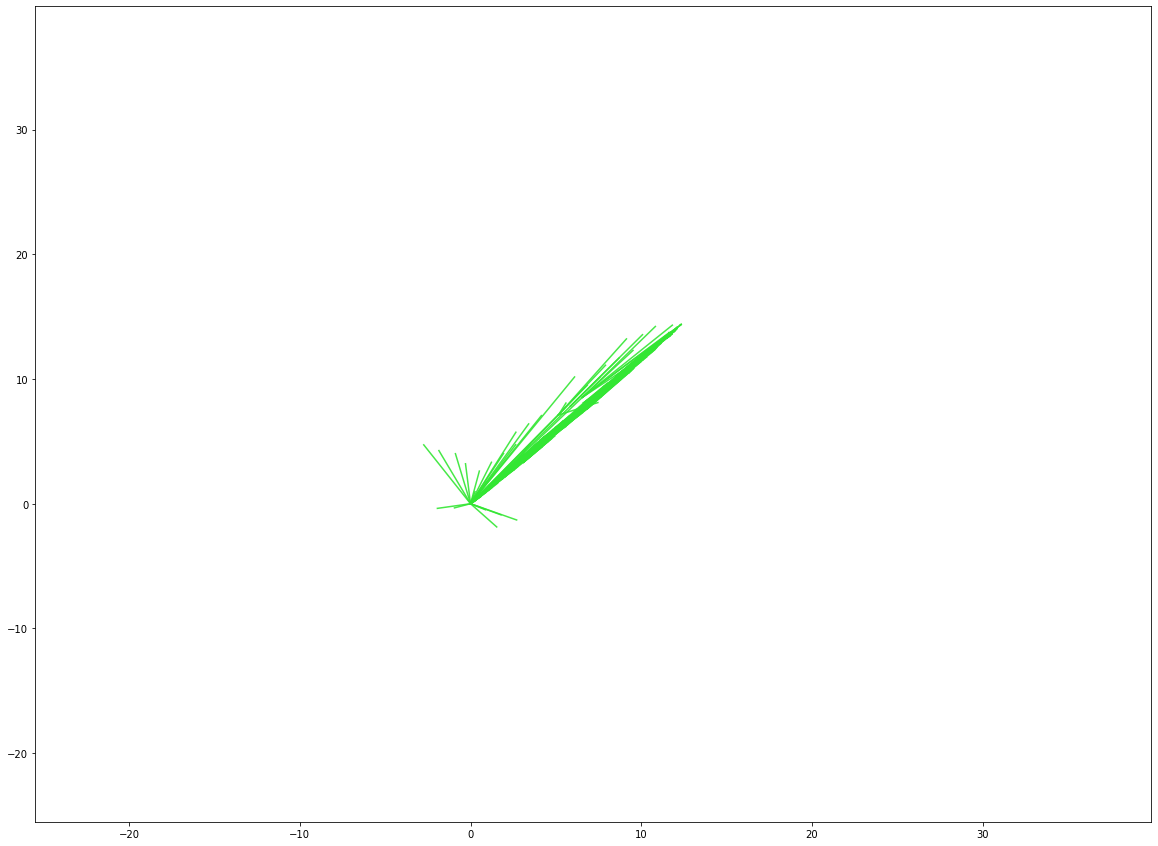

In [ ]:
# 지도 그리기
def draw_map(rrt, path):
    fig = plt.figure(figsize = (20, 15))
    ax = plt.axes()
    ax.axis([bounds[0]-0.5, bounds[1]+0.5, bounds[0]-0.5, bounds[1]+0.5])

    rrt.draw_graph(ax)
    rrt.draw_path(ax,path)
    rrt.map.plotobs(ax)
    plt.show()

draw_map(rrt,shortest_path)